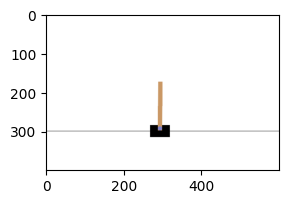

In [1]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('CartPole-v1',
                       render_mode='rgb_array',)

        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    # step 就是進行了一次行動
    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        over = terminated or truncated

        #限制最大步数
        self.step_n += 1
        if self.step_n >= 200:
            over = True
        
        #没坚持到最后,扣分
        if over and self.step_n < 200:
            reward = -1000

        return state, reward, over

    #打印游戏图像
    def show(self):
        from matplotlib import pyplot as plt
        plt.figure(figsize=(3, 3))
        plt.imshow(self.env.render())
        plt.show()


env = MyWrapper()

env.reset()

env.show()

In [2]:
import torch
import torch.nn as nn

# 定義 Q 網路類別
class QNetwork(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=64, output_dim=2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)

# 定義複製模型參數的函數
def clone_model(model):
    clone = QNetwork()  # 這裡假設結構一樣
    clone.load_state_dict(model.state_dict())
    return clone

# 建立主模型
model = QNetwork()
# 用 clone_model 複製出 target 模型
model_delay = clone_model(model)

In [3]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
    data = []
    reward_sum = 0

    state = env.reset()
    over = False
    while not over:
        action = model(torch.FloatTensor(state).reshape(1, 4)).argmax().item()
        if random.random() < 0.1:
            action = env.action_space.sample()

        next_state, reward, over = env.step(action)

        data.append((state, action, reward, next_state, over))
        reward_sum += reward

        state = next_state

        if show:
            display.clear_output(wait=True)
            env.show()

    return data, reward_sum


play()[-1]

d:\it_project\github_sync\ml-workshop\.venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


-990.0

In [4]:
#数据池
class Pool:

    def __init__(self):
        self.pool = []

    def __len__(self):
        return len(self.pool)

    def __getitem__(self, i):
        return self.pool[i]

    #更新动作池
    def update(self):
        #每次更新不少于N条新数据
        old_len = len(self.pool)
        while len(pool) - old_len < 200:
            self.pool.extend(play()[0])

        #只保留最新的N条数据
        self.pool = self.pool[-2_0000:]

    #获取一批数据样本
    def sample(self):
        data = random.sample(self.pool, 64)

        state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 4)
        action = torch.LongTensor([i[1] for i in data]).reshape(-1, 1)
        reward = torch.FloatTensor([i[2] for i in data]).reshape(-1, 1)
        next_state = torch.FloatTensor([i[3] for i in data]).reshape(-1, 4)
        over = torch.LongTensor([i[4] for i in data]).reshape(-1, 1)

        return state, action, reward, next_state, over


pool = Pool()
pool.update()
pool.sample()

len(pool), pool[0]

C:\Users\User\AppData\Local\Temp\ipykernel_156544\2282743005.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 4)


(209,
 (array([-0.03845878, -0.00227185,  0.02330334, -0.01129661], dtype=float32),
  1,
  1.0,
  array([-0.03850421,  0.19250828,  0.02307741, -0.29653692], dtype=float32),
  False))

In [5]:
#训练
def train():
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
    loss_fn = torch.nn.MSELoss()

    #共更新N轮数据
    for epoch in range(1000):
        pool.update()

        #每次更新数据后,训练N次
        for i in range(200):

            #采样N条数据
            state, action, reward, next_state, over = pool.sample()

            #计算value
            value = model(state).gather(dim=1, index=action)

            #计算target
            with torch.no_grad():
                #使用原模型计算动作,使用延迟模型计算target,进一步缓解自举
                next_action = model(next_state).argmax(dim=1, keepdim=True)
                target = model_delay(next_state).gather(dim=1,
                                                        index=next_action)
            target = target * 0.99 * (1 - over) + reward

            loss = loss_fn(value, target)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #复制参数
        if (epoch + 1) % 5 == 0:
            model_delay.load_state_dict(model.state_dict())

        if epoch % 100 == 0:
            test_result = sum([play()[-1] for _ in range(20)]) / 20
            print(epoch, len(pool), test_result)


train()

0 410 -852.35
100 20000 97.1
200 20000 200.0
300 20000 200.0
400 20000 200.0
500 20000 200.0
600 20000 200.0
700 20000 200.0
800 20000 200.0
900 20000 200.0


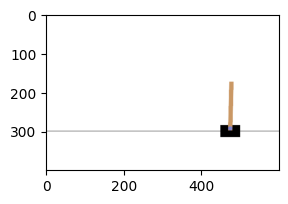

200.0

In [6]:
play(True)[-1]

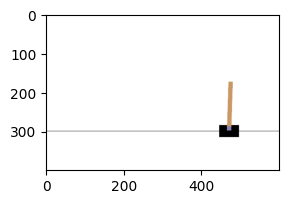

200.0

In [7]:
play(True)[-1]

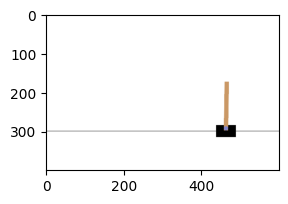

200.0

In [8]:
play(True)[-1]

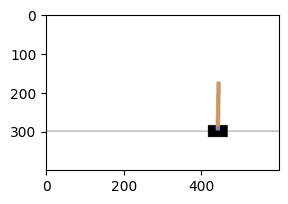

200.0

In [9]:
play(True)[-1]

In [10]:
import torch

model = QNetwork()
model_delay = clone_model(model)
pool = Pool()       # 重新開一個資料池
pool.update()       # 重新收集資料

def train_with_save_best_model():
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
    loss_fn = torch.nn.MSELoss()
    best_score = float('-inf')  # 記錄最高分
    best_epoch = -1             # 記錄最高分是哪個 epoch

    for epoch in range(1000):
        pool.update()
        for i in range(200):
            state, action, reward, next_state, over = pool.sample()

            value = model(state).gather(dim=1, index=action)
            with torch.no_grad():
                target = model_delay(next_state)
            target = target.max(dim=1)[0].reshape(-1, 1)
            target = target * 0.99 * (1 - over) + reward

            loss = loss_fn(value, target)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # target network 更新
        if (epoch + 1) % 5 == 0:
            model_delay.load_state_dict(model.state_dict())

        # 每100回合評估一次
        if epoch % 100 == 0:
            test_result = sum([play()[-1] for _ in range(20)]) / 20
            print(f"Epoch {epoch}, Pool Size: {len(pool)}, Test Score: {test_result:.2f}")
            # 如果這次分數比以前高，就存下來
            if test_result > best_score:
                best_score = test_result
                best_epoch = epoch
                torch.save(model.state_dict(), 'best_model.pth')
                print(f"Best model saved at epoch {epoch} with score {test_result:.2f}")

    print(f"訓練結束，最高分：{best_score:.2f}，出現在 epoch {best_epoch}，模型已存為 'best_model.pth'。")


train_with_save_best_model()


Epoch 0, Pool Size: 411, Test Score: -959.40
Best model saved at epoch 0 with score -959.40
Epoch 100, Pool Size: 20000, Test Score: 200.00
Best model saved at epoch 100 with score 200.00
Epoch 200, Pool Size: 20000, Test Score: 200.00
Epoch 300, Pool Size: 20000, Test Score: 200.00
Epoch 400, Pool Size: 20000, Test Score: 200.00
Epoch 500, Pool Size: 20000, Test Score: 200.00
Epoch 600, Pool Size: 20000, Test Score: 200.00
Epoch 700, Pool Size: 20000, Test Score: 96.30
Epoch 800, Pool Size: 20000, Test Score: 200.00
Epoch 900, Pool Size: 20000, Test Score: 200.00
訓練結束，最高分：200.00，出現在 epoch 100，模型已存為 'best_model.pth'。


In [11]:
best_model = QNetwork()
best_model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [12]:
def play_with_model(model, show=False):
    data = []
    reward_sum = 0

    state = env.reset()
    over = False
    while not over:
        action = model(torch.FloatTensor(state).reshape(1, 4)).argmax().item()
        if random.random() < 0.1:
            action = env.action_space.sample()

        next_state, reward, over = env.step(action)

        data.append((state, action, reward, next_state, over))
        reward_sum += reward

        state = next_state

        if show:
            display.clear_output(wait=True)
            env.show()

    return data, reward_sum


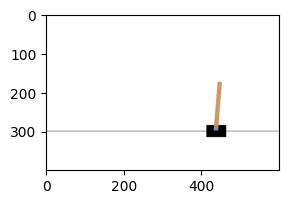

Best model 得分： 200.0


In [15]:
score = play_with_model(best_model, show=True)[-1]
print("Best model 得分：", score)